# Customer Segmentation

In [1]:
import os
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## Format Date Column

In [2]:
data = pd.read_csv("data{}KaDo.csv".format(os.sep), sep=",")

data.info()

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,35592159,10,1.66,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,35592159,10,7.45,SOINS DU VISAGE,VIS_CJOUR Jeunes Specifique,VIS_JEUNE_ET_LEVRE,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,35592159,10,5.95,SOINS DU VISAGE,VIS_DEMAQ AAAR,VIS_AAAR_DEMAQLOTION,EAU MICELLAIRE 3 THES FL200ML,1490281
4,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 TIARE FL 200ML,1490281


In [3]:
data["MOIS_VENTE"] = data["MOIS_VENTE"].apply(lambda x: "2021-{}-01 12:50:00".format(x))
data = data.assign(QUANTITY=lambda x: 1)

data.head()

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID,QUANTITY
0,35592159,2021-10-01 12:50:00,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281,1
1,35592159,2021-10-01 12:50:00,1.66,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281,1
2,35592159,2021-10-01 12:50:00,7.45,SOINS DU VISAGE,VIS_CJOUR Jeunes Specifique,VIS_JEUNE_ET_LEVRE,CR JR PARF BIO.SPE AC.SENT.50ML,1490281,1
3,35592159,2021-10-01 12:50:00,5.95,SOINS DU VISAGE,VIS_DEMAQ AAAR,VIS_AAAR_DEMAQLOTION,EAU MICELLAIRE 3 THES FL200ML,1490281,1
4,35592159,2021-10-01 12:50:00,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 TIARE FL 200ML,1490281,1


## Data Insights

<AxesSubplot:>

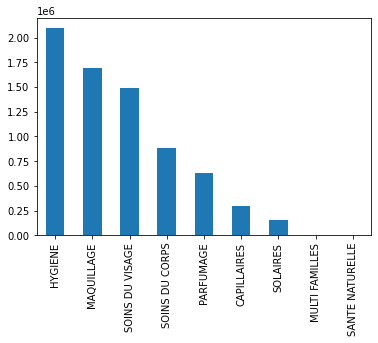

In [4]:
data["FAMILLE"].value_counts()[:10].plot(kind='bar')

<AxesSubplot:>

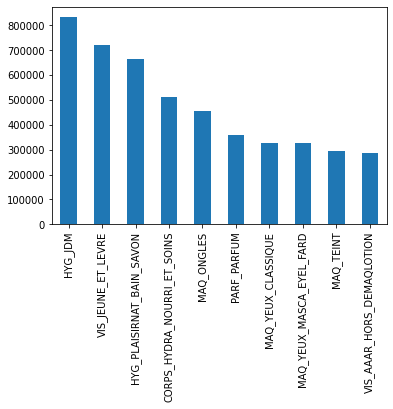

In [5]:
data["MAILLE"].value_counts()[:10].plot(kind='bar')

<AxesSubplot:>

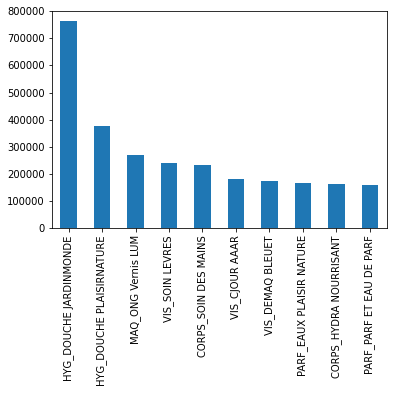

In [6]:
data["UNIVERS"].value_counts()[:10].plot(kind='bar')

In [7]:
filtered_data = data.copy()
filtered_data = filtered_data[[
    "CLI_ID", "MOIS_VENTE", "TICKET_ID", "QUANTITY", "PRIX_NET"
]]

filtered_data["MOIS_VENTE"].min(), filtered_data["MOIS_VENTE"].max()

('2021-1-01 12:50:00', '2021-9-01 12:50:00')

In [8]:
PRESENT = dt.datetime(2022, 1, 1)

filtered_data["MOIS_VENTE"] = pd.to_datetime(filtered_data["MOIS_VENTE"])

filtered_data.head()

,CLI_ID,MOIS_VENTE,TICKET_ID,QUANTITY,PRIX_NET
0,1490281,2021-10-01 12:50:00,35592159,1,1.67
1,1490281,2021-10-01 12:50:00,35592159,1,1.66
2,1490281,2021-10-01 12:50:00,35592159,1,7.45
3,1490281,2021-10-01 12:50:00,35592159,1,5.95
4,1490281,2021-10-01 12:50:00,35592159,1,1.67


## RFM

In [10]:
rfm = filtered_data.groupby("CLI_ID").agg({
    "MOIS_VENTE":
    lambda date: (PRESENT - date.max()).days,
    "TICKET_ID":
    lambda num: len(num),
    "PRIX_NET":
    lambda price: price.sum()
})

rfm.columns

Index(['MOIS_VENTE', 'TICKET_ID', 'PRIX_NET'], dtype='object')

In [11]:
rfm.rename(columns={"PRIX_NET": "monetary", "TICKET_ID": "frequency", "MOIS_VENTE": "recency"}, inplace=True)
rfm["recency"] = rfm["recency"].astype(int)

rfm.head()

,recency,frequency,monetary
CLI_ID,,,
1490281,91,5,18.40
13290776,30,9,55.50
20163348,364,1,7.45
20200041,364,2,6.70
20561854,305,3,7.05


### Quartile of RFM

In [12]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 3, ['1','2','3'], duplicates='drop')
rfm["f_quartile"] = pd.qcut(rfm["frequency"], 3, ['3', '2', '1'], duplicates='drop')
rfm["m_quartile"] = pd.qcut(rfm["monetary"],
                            3, ['3', '2', '1'],
                            duplicates='drop')

rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CLI_ID,,,,,,
1490281,91,5,18.40,2,2,2
13290776,30,9,55.50,1,1,1
20163348,364,1,7.45,3,3,3
20200041,364,2,6.70,3,3,3
20561854,305,3,7.05,3,3,3


In [13]:
rfm["RFM_Score"] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)

rfm.head(10)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CLI_ID,,,,,,,
1490281,91,5,18.40,2,2,2,222
13290776,30,9,55.50,1,1,1,111
20163348,364,1,7.45,3,3,3,333
20200041,364,2,6.70,3,3,3,333
20561854,305,3,7.05,3,3,3,333
20727324,364,5,13.25,3,2,3,323
20791601,244,4,23.80,3,2,2,322
21046542,183,32,166.20,3,1,1,311
21239163,364,5,12.65,3,2,3,323


In [19]:
rfm_display = rfm.copy()

rfm_display["recency"] = rfm_display["recency"] / 30
rfm_display["recency"] = round(rfm_display["recency"], 0).astype(int)

rfm_display.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CLI_ID,,,,,,,
1490281,3,5,18.40,2,2,2,222
13290776,1,9,55.50,1,1,1,111
20163348,12,1,7.45,3,3,3,333
20200041,12,2,6.70,3,3,3,333
20561854,10,3,7.05,3,3,3,333


#### Recency

<AxesSubplot:xlabel='Recency', ylabel='Sales'>

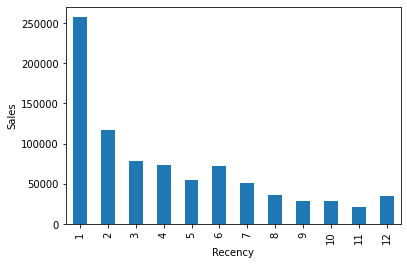

In [27]:
rfm_display = rfm_display.sort_values("recency")
rfm_display["recency"].value_counts(sort=False)[:12].plot(kind='bar', xlabel="Recency", ylabel="Sales")

#### Frequency

<AxesSubplot:xlabel='Number of Tickets per Customer', ylabel='Sales'>

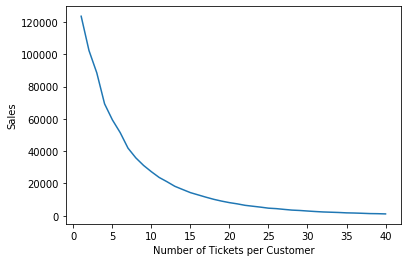

In [41]:
rfm_display = rfm_display.sort_values("frequency")
rfm_display["frequency"].value_counts(sort=False)[:40].plot(kind='line', xlabel="Number of Tickets per Customer", ylabel="Sales")

#### Monetary

<AxesSubplot:xlabel='Amount Spent', ylabel='Sales'>

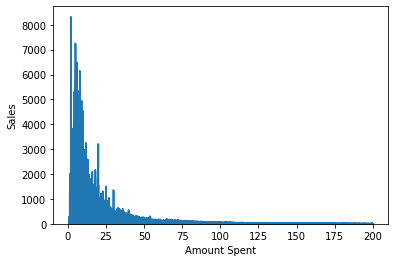

In [56]:
rfm_display = rfm_display.sort_values("monetary")
rfm_display["monetary"].value_counts(sort=False)[:200].plot(
    kind='area', xlabel="Amount Spent", ylabel="Sales")


<AxesSubplot:xlabel='Amount Spent', ylabel='Sales'>

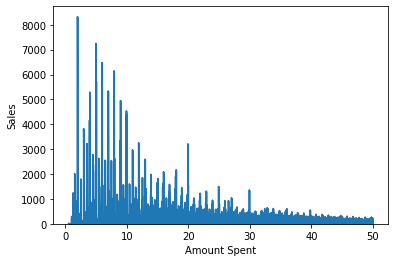

In [65]:
rfm_display["monetary"].value_counts(sort=False)[:50].plot(
    kind='area', xlabel="Amount Spent", ylabel="Sales")

#### RFM Score

<AxesSubplot:title={'center':'Number of customers per RFM Score'}, xlabel='RFM Score', ylabel=' Nbr of customers'>

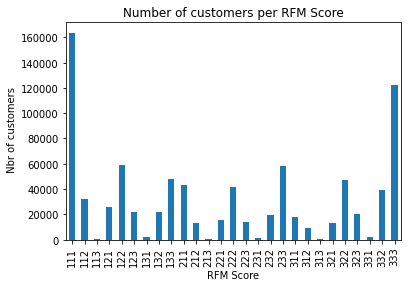

In [76]:
rfm_display = rfm_display.sort_values("RFM_Score")
rfm_display["RFM_Score"].value_counts(sort=False).plot(
    kind='bar', ylabel=" Nbr of customers", xlabel="RFM Score", title="Number of customers per RFM Score")

<AxesSubplot:title={'center':'10 most present RFM Score repartition'}>

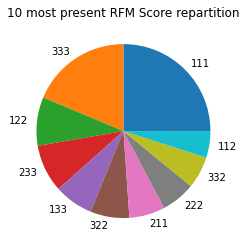

In [84]:
rfm_display["RFM_Score"].value_counts()[:10].plot(
    kind='pie',
    ylabel='',
    title="10 most present RFM Score repartition")


#### Filter out best customer

In [15]:
best_customers = rfm[rfm["RFM_Score"] == "111"].sort_values('monetary', ascending=False)

best_customers.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CLI_ID,,,,,,,
967051620,30,359,13536.95,1,1,1,111
977936472,30,258,5549.75,1,1,1,111
975243811,30,365,4487.75,1,1,1,111
975127123,30,834,3934.08,1,1,1,111
978847890,30,325,3860.35,1,1,1,111


#### Percentage best customers

In [91]:
"{}%".format(round(best_customers.shape[0] / len(data["CLI_ID"].unique()) * 100, 2))

'Percentage best customers: 19.18%'